# SemEval 2025 Task 9: The Food Hazard Detection Challenge

This notebook addresses the [**Food Hazard Detection** task from SemEval 2025](https://food-hazard-detection-semeval-2025.github.io/), which involves identifying food-related hazards and affected products from food-incident reports collected from the web. The goal is to classify incidents based on textual descriptions, aiding in food safety monitoring.  

To tackle this problem, we fine-tuned **BERT-based transformer models**, including **BERT-mini** and **DistilBERT**, on the provided dataset. We tokenized the text using the BERT tokenizer, and trained the model using a weighted cross-entropy loss to handle class imbalances.

Our approach includes early stopping based on validation loss, a learning rate scheduler, and mixed-precision training for efficiency. Finally, we evaluated performance using macro-F1 scores and generated predictions for both the validation and test set.

## Setup

- This notebook requires a few Python libraries for machine learning, natural language processing, and data handling.

- If you don’t have them installed, run the code below in the first cell of the notebook.

In [1]:
%pip install torch transformers datasets pandas scikit-learn nltk

Note: you may need to restart the kernel to use updated packages.


- As a first step, we need to import the necessary libraries.

In [2]:
import pandas as pd
import numpy as np
import random
import nltk
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, classification_report
from sklearn.utils.class_weight import compute_class_weight

import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.cuda.amp import GradScaler, autocast

from transformers import (
    BertTokenizer, 
    DistilBertTokenizer,
    BertForSequenceClassification, 
    DistilBertForSequenceClassification,
    get_scheduler, 
    DataCollatorWithPadding
)

from datasets import Dataset
from tqdm.auto import tqdm
from nltk.corpus import wordnet

- The CSV files for [training](incidents_train.csv), [validation](incidents_valid.csv), and [testing](incidents_test.csv) are located in the same directory as this notebook.

- We read these files.

In [ ]:
# Load training data
train_df = pd.read_csv('data/incidents_train.csv', index_col=0)
dev_df = pd.read_csv('data/incidents_valid.csv', index_col=0)
test_df = pd.read_csv('data/incidents_test.csv', index_col=0)

- Let's take a look at some statistics of our training data.

In [4]:
# Number of lines
num_lines = len(train_df)

# Number of unique labels
unique_hazard_category = train_df['hazard-category'].nunique()
unique_product_category = train_df['product-category'].nunique()
unique_hazard = train_df['hazard'].nunique()
unique_product = train_df['product'].nunique()

# Average size of title and text
avg_title_length = train_df['title'].apply(len).mean()
avg_text_length = train_df['text'].apply(len).mean()

print(f"Number of lines: {num_lines}")
print(f"Number of unique hazard categories: {unique_hazard_category}")
print(f"Number of unique product categories: {unique_product_category}")
print(f"Number of unique hazards: {unique_hazard}")
print(f"Number of unique products: {unique_product}")
print(f"Average title length: {avg_title_length:.2f}")
print(f"Average text length: {avg_text_length:.2f}")

Number of lines: 5082
Number of unique hazard categories: 10
Number of unique product categories: 22
Number of unique hazards: 128
Number of unique products: 1022
Average title length: 88.06
Average text length: 2335.49


- Given the dataset size (5,082 training samples) and the length of the text fields (with an average of 2,335 characters per text), using a transformer-based model is beneficial for capturing contextual information.  

- We experimented with various models, including **BERT (110M parameters), DeBERTa (86M+ parameters), RoBERTa (125M parameters), DistilBERT (66M parameters),** and **TinyBERT (14M parameters)**, but found that **BERT-mini (11M parameters) and DistilBERT (66M parameters)** achieved the best results.  

- **BERT-mini** was optimal for `hazard-category`, `product-category` and `hazard` classification.  

- For `product` classification, we used **DistilBERT**. The choice was driven by the need for a slightly larger model that could handle the broader and more nuanced product categories effectively.  

- Larger models, while powerful, tended to overfit due to the relatively small dataset size, learning noise instead of generalizable patterns.  

- Next, we initialize the tokenizer.

In [5]:
# Tokenizer for categories and hazards (BERT)
tokenizer_bert = BertTokenizer.from_pretrained('prajjwal1/bert-mini')

# Tokenizer for products (DistilBERT)
tokenizer_distilbert = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

- We set a random seed to improve reproducibility, though some level of randomness remains.

In [6]:
def set_seed(seed=2024):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(2024)

## Define Basic Functions

- We define the tokenization function.  

- We combine the **title** and **text** fields into a single string for better contextual understanding.  

- If using **BERT-mini**, we set a max length of **512 tokens** to ensure consistency and prevent exceeding the model’s input limit.  

- For **DistilBERT**, we allow dynamic padding to maintain efficiency without unnecessarily increasing input length.

In [7]:
def tokenize_function(examples, tokenizer=tokenizer_bert):
    # Combine title and text into one string
    combined_text = [
        f"Title: {title} Text: {text}"
        for title, text in zip(examples['title'], examples['text'])
    ]
    
    # Tokenize the combined text
    if isinstance(tokenizer, BertTokenizer) or isinstance(tokenizer, DistilBertTokenizer):
        # Use max length for BERT
        if isinstance(tokenizer, BertTokenizer):
            return tokenizer(
                combined_text, 
                padding='max_length', 
                truncation=True, 
                max_length=512  # Explicitly set max length for BERT
            )
        # Do not use max length for DistilBERT
        else:
            return tokenizer(
                combined_text, 
                padding=True, 
                truncation=True
            )

- We define the `prepare_data` function.

- This function encodes the labels using `LabelEncoder` to convert categorical labels into numerical format.

- We encode labels from all datasets to ensure consistency, as some labels may appear in the validation or test sets but not in the training set.

- Encoding all labels across datasets may not be ideal in real-world applications, as it could lead to potential data leakage or mismatch issues. However, we do this here to avoid errors and ensure smooth processing when labels are not consistent across the datasets.  

- We apply the tokenization function to the training, validation, and test datasets.

- The datasets are formatted to be compatible with PyTorch by setting columns for input IDs, attention masks, and labels.

- DataLoader objects are created for training, validation, and test datasets with batching and padding.

In [8]:
def prepare_data(train_df, label, tokenizer=tokenizer_bert):
    # Initialize LabelEncoder
    label_encoder = LabelEncoder()
    
    # Fit the label encoder on the combined labels from train, dev, and test datasets
    label_encoder.fit(list(train_df[label]) + list(dev_df[label]) + list(test_df[label]))

    # Transform the labels to numerical format
    train_df['label'] = label_encoder.transform(train_df[label])
    dev_df['label'] = label_encoder.transform(dev_df[label])
    test_df['label'] = label_encoder.transform(test_df[label])

    # Convert pandas DataFrames to Hugging Face Datasets
    train_dataset = Dataset.from_pandas(train_df)
    dev_dataset = Dataset.from_pandas(dev_df)
    test_dataset = Dataset.from_pandas(test_df)

    # Apply tokenization function to the datasets
    train_dataset = train_dataset.map(tokenize_function, batched=True)
    dev_dataset = dev_dataset.map(tokenize_function, batched=True)
    test_dataset = test_dataset.map(tokenize_function, batched=True)

    # Initialize data collator for padding
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    # Set format for PyTorch compatibility
    train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
    dev_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
    test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

    # Create DataLoader objects for train, dev, and test datasets
    return (
        DataLoader(train_dataset, shuffle=True, batch_size=8, collate_fn=data_collator),
        DataLoader(dev_dataset, batch_size=8, collate_fn=data_collator),
        DataLoader(test_dataset, batch_size=8, collate_fn=data_collator),
        label_encoder
    )

- The following function (`compute_score`) computes the score as defined by the task.

- It calculates the **macro F1 score** for both hazards and products.

- The F1 score for products is computed only for the instances where the predicted hazards match the true hazards.

- The final score is the average of the hazard F1 score and the product F1 score.

In [9]:
def compute_score(hazards_true, products_true, hazards_pred, products_pred):
  # compute f1 for hazards:
  f1_hazards = f1_score(
    hazards_true,
    hazards_pred,
    average='macro'
  )

  # compute f1 for products:
  f1_products = f1_score(
    products_true[hazards_pred == hazards_true],
    products_pred[hazards_pred == hazards_true],
    average='macro'
  )

  return (f1_hazards + f1_products) / 2.

- The function `synonym_replacement` randomly replaces **n** words in the text with their synonyms from WordNet.

- We will use this function later for data augmentation.

In [10]:
# Download the WordNet data for synonym replacement
nltk.download('wordnet')

# Replace n words in the text with their synonyms from WordNet
def synonym_replacement(text, n=2):
    words = text.split()
    new_words = words.copy()
    for _ in range(n):
        word = random.choice(words)
        synonyms = wordnet.synsets(word)
        if synonyms:
            synonym = synonyms[0].lemmas()[0].name().replace("_", " ")
            new_words = [synonym if w == word else w for w in new_words]
    return " ".join(new_words)

[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


- We define the **`augment_low_frequency_classes`** function to address class imbalance by augmenting underrepresented classes.

- It identifies low-frequency classes in the given column, applies the **`synonym_replacement`** function on their text, and adds them back to the training dataset.

- The dataset is then shuffled for randomness.

In [11]:
def augment_low_frequency_classes(column, threshold):
    # Identify low-frequency classes
    class_counts = train_df[column].value_counts()
    low_freq_classes = class_counts[class_counts < threshold].index

    # Filter out underrepresented class samples
    low_freq_samples = train_df[train_df[column].isin(low_freq_classes)].copy()

    if low_freq_samples.empty:
        print(f"No low-frequency classes found in '{column}' below the threshold of {threshold}.")
        return train_df

    # Apply augmentation
    low_freq_samples["text"] = low_freq_samples["text"].apply(synonym_replacement)

    # Add augmented samples to original dataset
    augmented_df = pd.concat([train_df, low_freq_samples])

    # Shuffle the dataset
    augmented_df = augmented_df.sample(frac=1, random_state=42).reset_index(drop=True)

    print(f"Original dataset size: {len(train_df)}")  # Before augmentation
    print(f"Augmented dataset size: {len(augmented_df)}")  # After augmentation

    return augmented_df

- We use the `plot_loss_curve` function to visualize the training and validation loss over epochs.

- The function plots **train loss** and **validation loss** on the same graph to help monitor model performance.

- This helps in detecting overfitting, underfitting, and tracking the progress of the training process.

In [12]:
def plot_loss_curve(train_losses, val_losses, label):
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss", marker="o")
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Loss Curve for {label}")
    plt.legend()
    plt.grid()
    plt.show()

- We use the `initialize_model` function to load a pre-trained transformer model, either **BERT** or **DistilBERT**, based on the specified model name.  

- The model is initialized with a number of labels matching the unique categories in the dataset.  

- It is then moved to the GPU for faster processing.  

- The total number of model parameters is calculated and displayed to provide insight into model complexity.

In [ ]:
def initialize_model(labels, model_name='prajjwal1/bert-mini'):
    # Check if the model is BERT or DistilBERT and load the appropriate model
    if 'distilbert' in model_name.lower():
        model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=len(labels))
    else:
        model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(labels))
    
    model.to('cuda')
    total_params = sum(p.numel() for p in model.parameters())
    
    # Uncomment the following line to print the model
    # print(model)
    print(f"Total Parameters: {total_params:,}")
    return model

- We use the `evaluate` function to compute the validation loss on the development dataset.

- The model is set to evaluation mode to disable gradient computation.

- The function iterates over the validation dataloader, calculating the loss for each batch and summing it up.

In [14]:
def evaluate(model, dev_dataloader):
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in dev_dataloader:
            batch = {k: v.to('cuda') for k, v in batch.items()}
            outputs = model(**batch)
            total_val_loss += outputs.loss.item()
    return total_val_loss

- We use the `test_and_predict` function to generate predictions on the test dataset.

- The model is set to evaluation mode, and predictions are made for each batch in the test dataloader.

- The function uses `torch.argmax` to extract the predicted class for each instance.

- The predicted labels are then transformed back into their original form using the `label_encoder`.

In [15]:
def test_and_predict(model, test_dataloader, label_encoder):
    model.eval()
    total_predictions = []
    with torch.no_grad():
        for batch in test_dataloader:
            batch = {k: v.to('cuda') for k, v in batch.items()}
            outputs = model(**batch)
            predictions = torch.argmax(outputs.logits, dim=-1)
            total_predictions.extend([p.item() for p in predictions])
    
    predicted_labels = label_encoder.inverse_transform(total_predictions)
    return predicted_labels

- We use the `validate_and_predict` function to generate predictions on the validation dataset.  

- The model is set to evaluation mode, and predictions are made for each batch in the validation dataloader.  

- The function applies `torch.argmax` to obtain the predicted class for each instance.  

- The predicted labels are converted back to their original form using the `label_encoder`.  

In [16]:
def validate_and_predict(model, dev_dataloader, label_encoder):
    model.eval()
    total_predictions = []
    with torch.no_grad():
        for batch in dev_dataloader:
            batch = {k: v.to('cuda') for k, v in batch.items()}
            outputs = model(**batch)
            predictions = torch.argmax(outputs.logits, dim=-1)
            total_predictions.extend([p.item() for p in predictions])
    
    predicted_labels = label_encoder.inverse_transform(total_predictions)
    return predicted_labels

- We use the `compute_class_weights` function to handle class imbalance in the dataset.

- The function calculates class weights based on the frequency of labels in the training data using the `compute_class_weight` method.

- We assign higher weights to underrepresented classes to address the class imbalance issue.

- The computed class weights are then converted to a tensor and moved to the GPU for use during training.

In [17]:
def compute_class_weights(label, all_labels):
    # Create a mapping of label names to integer indices
    label_to_idx = {label: idx for idx, label in enumerate(all_labels)}
    
    # Convert only training labels to indices
    train_label_indices = np.array([label_to_idx[l] for l in train_df[label].astype(str).values])
    
    # Compute class weights for labels **present in training data**
    train_classes = np.unique(train_label_indices)
    train_class_weights = compute_class_weight('balanced', classes=train_classes, y=train_label_indices)
    
    # Initialize weights with default value 1.0 for all labels
    class_weights = np.ones(len(all_labels), dtype=np.float32)
    
    # Assign computed weights to known training labels
    for i, cls in enumerate(train_classes):
        class_weights[cls] = train_class_weights[i]  # Apply computed weight
    
    # Convert to tensor
    class_weights = torch.tensor(class_weights, dtype=torch.float).to('cuda')

    # Uncomment the following line to print the class weights
    # for cls, weight in zip(np.unique(train_df[label].values), class_weights):
    #     print(f"Class {cls}: Weight {weight:.4f}")
    
    return class_weights

- The `train_and_evaluate` function trains the model and evaluates its performance on the validation set.

- We collect all unique labels from the train, dev, and test datasets to initialize the model with the correct number of classes.

- The function uses **AdamW** optimizer with a learning rate of `3e-5` and weight decay for regularization.

- A **learning rate scheduler** is applied to adjust the learning rate throughout training.

- **Gradient scaling** with `GradScaler` is used to prevent gradient overflow during training with mixed precision.

- The model is trained for a maximum of 50 epochs, with **early stopping** to prevent overfitting if validation loss doesn't improve for 3 consecutive epochs.

- The **cross-entropy loss** function is customized with class weights to handle class imbalance.

- After training, the model's performance is evaluated on the test set, and predictions are compared to the gold labels using **classification metrics**.

- The loss curve is plotted to visualize the training and validation loss over time.

In [18]:
def train_and_evaluate(train_dataloader, dev_dataloader, test_dataloader, label_encoder, label, save_path):    
    # Collect all unique labels from train, dev, and test sets
    all_labels = sorted(set(train_df[label].astype(str).unique()) | 
                        set(dev_df[label].astype(str).unique()) | 
                        set(test_df[label].astype(str).unique()))
    
    # Initialize the model with the unique labels and select the model based on the label type
    model_name = 'distilbert-base-uncased' if label == 'product' else 'prajjwal1/bert-mini'
    model = initialize_model(all_labels, model_name)

    # Set up the optimizer, learning rate scheduler, and gradient scaler
    optimizer = AdamW(model.parameters(), lr=3e-5, weight_decay=0.01)
    num_epochs = 50
    num_training_steps = num_epochs * len(train_dataloader)
    lr_scheduler = get_scheduler(name="linear", optimizer=optimizer, num_warmup_steps=int(0.1 * num_training_steps), num_training_steps=num_training_steps)
    scaler = GradScaler()
    model.train()
    progress_bar = tqdm(range(num_training_steps))

    # Initialize variables for tracking best validation loss and early stopping
    best_loss = float('inf')
    train_losses = []
    val_losses = []
    patience = 3  # Number of epochs to wait for improvement
    counter = 0  # Tracks how many epochs have passed without improvement

    # Compute class weights to handle class imbalance
    class_weights = compute_class_weights(label, all_labels)

    for epoch in range(num_epochs):
        total_loss = 0
        model.train()  # Set model to training mode
        for batch in train_dataloader:
            batch = {k: v.to('cuda') for k, v in batch.items()}
            with autocast():
                # Custom loss function with class weights
                criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
                outputs = model(**batch)
                loss = criterion(outputs.logits, batch['labels'].to('cuda'))
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            lr_scheduler.step()
            optimizer.zero_grad()
            total_loss += loss.item()
            progress_bar.update(1)

        # Calculate average training loss for the epoch
        avg_train_loss = total_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)

        # Evaluate the model on the validation set
        total_val_loss = evaluate(model, dev_dataloader)
        avg_val_loss = total_val_loss / len(dev_dataloader)
        val_losses.append(avg_val_loss)

        # Print training and validation loss for the epoch
        avg_loss = total_loss / len(train_dataloader)
        print(f"Epoch {epoch+1}: Avg Train Loss = {avg_loss:.4f}, Avg Validation Loss = {avg_val_loss:.4f}")
        
        # Early Stopping Logic (based on validation loss)
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            counter = 0  # Reset patience counter if loss improves
        else:
            counter += 1
            print(f"No improvement in validation loss for {counter} epochs.")
            if counter >= patience:
                print("Early stopping triggered.")
                break

    validation_predictions = validate_and_predict(model, dev_dataloader, label_encoder)
    gold_labels = label_encoder.inverse_transform(dev_df.label.values)
    print("Validation Set Results:")
    print(classification_report(gold_labels, validation_predictions, zero_division=0))

    # Generate predictions on the test set
    predicted_labels = test_and_predict(model, test_dataloader, label_encoder)
    gold_labels = label_encoder.inverse_transform(test_df.label.values)
    print("Test Set Results:")
    print(classification_report(gold_labels, predicted_labels, zero_division=0))

    # Save predictions to the validation dataframe
    dev_df[f'predictions-{label}'] = validation_predictions

    # Save predictions to the test dataframe
    test_df[f'predictions-{label}'] = predicted_labels

    # Plot Training vs Validation Loss
    plot_loss_curve(train_losses, val_losses, label)
    
    model.save_pretrained(save_path)
    np.save(f"{save_path}/label_encoder.npy", label_encoder.classes_)

## Sub-Task 1

### Label: Hazard Category

- We call the **`prepare_data`** function to preprocess the dataset and create data loaders for training, validation, and testing.

In [19]:
train_dataloader, dev_dataloader, test_dataloader, label_encoder = prepare_data(train_df, 'hazard-category')

Map:   0%|          | 0/5082 [00:00<?, ? examples/s]

Map:   0%|          | 0/565 [00:00<?, ? examples/s]

Map:   0%|          | 0/997 [00:00<?, ? examples/s]

- We call the **`train_and_evaluate`** function to train and evaluate the model on the prepared data.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-mini and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total Parameters: 11,173,130


  0%|          | 0/31800 [00:00<?, ?it/s]

Epoch 1: Avg Train Loss = 2.2039, Avg Validation Loss = 1.8934
Epoch 2: Avg Train Loss = 1.9036, Avg Validation Loss = 1.2476
Epoch 3: Avg Train Loss = 1.4785, Avg Validation Loss = 0.7191
Epoch 4: Avg Train Loss = 1.0829, Avg Validation Loss = 0.5018
Epoch 5: Avg Train Loss = 0.7750, Avg Validation Loss = 0.3660
Epoch 6: Avg Train Loss = 0.5282, Avg Validation Loss = 0.2866
Epoch 7: Avg Train Loss = 0.3678, Avg Validation Loss = 0.2666
Epoch 8: Avg Train Loss = 0.2612, Avg Validation Loss = 0.2643
Epoch 9: Avg Train Loss = 0.1889, Avg Validation Loss = 0.2229
Epoch 10: Avg Train Loss = 0.1411, Avg Validation Loss = 0.2280
No improvement in validation loss for 1 epochs.
Epoch 11: Avg Train Loss = 0.1254, Avg Validation Loss = 0.2721
No improvement in validation loss for 2 epochs.
Epoch 12: Avg Train Loss = 0.0877, Avg Validation Loss = 0.2543
No improvement in validation loss for 3 epochs.
Early stopping triggered.
Validation Set Results:
                                precision    re

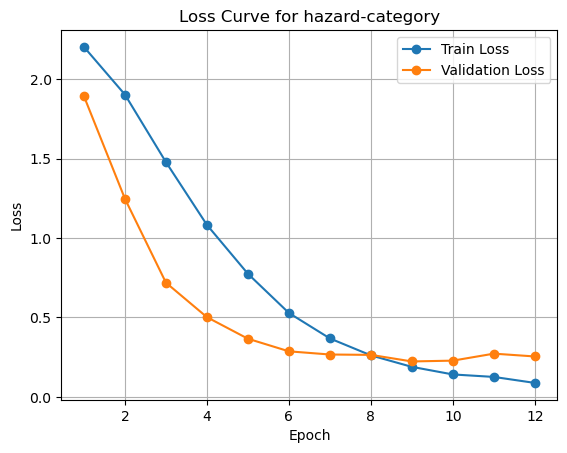

In [20]:
train_and_evaluate(train_dataloader, dev_dataloader, test_dataloader, label_encoder, 'hazard-category', "bert-mini_hazard_category")

### Label: Product Category

- We call the **`prepare_data`** function to preprocess the dataset and create data loaders for training, validation, and testing.

In [21]:
train_dataloader, dev_dataloader, test_dataloader, label_encoder = prepare_data(train_df, 'product-category')

Map:   0%|          | 0/5082 [00:00<?, ? examples/s]

Map:   0%|          | 0/565 [00:00<?, ? examples/s]

Map:   0%|          | 0/997 [00:00<?, ? examples/s]

- We call the **`train_and_evaluate`** function to train and evaluate the model on the prepared data.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-mini and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total Parameters: 11,176,214


  0%|          | 0/31800 [00:00<?, ?it/s]

Epoch 1: Avg Train Loss = 3.0659, Avg Validation Loss = 2.9268
Epoch 2: Avg Train Loss = 2.9549, Avg Validation Loss = 2.7703
Epoch 3: Avg Train Loss = 2.8248, Avg Validation Loss = 2.4648
Epoch 4: Avg Train Loss = 2.3981, Avg Validation Loss = 1.9108
Epoch 5: Avg Train Loss = 1.9223, Avg Validation Loss = 1.4964
Epoch 6: Avg Train Loss = 1.5129, Avg Validation Loss = 1.2100
Epoch 7: Avg Train Loss = 1.1698, Avg Validation Loss = 1.0801
Epoch 8: Avg Train Loss = 0.9147, Avg Validation Loss = 0.9958
Epoch 9: Avg Train Loss = 0.7378, Avg Validation Loss = 0.9790
Epoch 10: Avg Train Loss = 0.5771, Avg Validation Loss = 0.9783
Epoch 11: Avg Train Loss = 0.4701, Avg Validation Loss = 0.9555
Epoch 12: Avg Train Loss = 0.3787, Avg Validation Loss = 0.9703
No improvement in validation loss for 1 epochs.
Epoch 13: Avg Train Loss = 0.3058, Avg Validation Loss = 0.9672
No improvement in validation loss for 2 epochs.
Epoch 14: Avg Train Loss = 0.2463, Avg Validation Loss = 0.9702
No improvement in

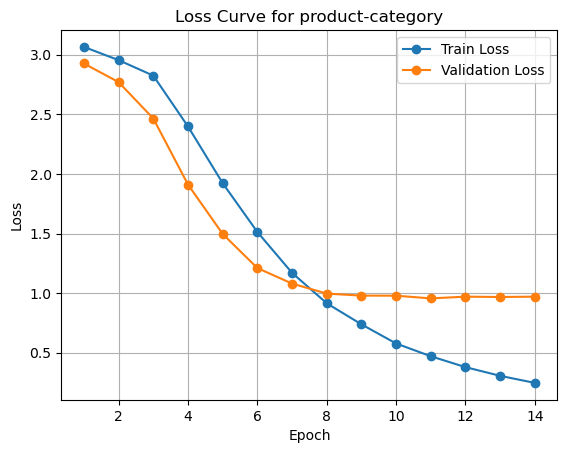

In [22]:
train_and_evaluate(train_dataloader, dev_dataloader, test_dataloader, label_encoder, 'product-category', "bert-mini_product_category")

- We calculate the F1 **validation score** for both the hazard and product categories.

In [23]:
validation_score = compute_score(
    dev_df['hazard-category'], dev_df['product-category'],
    dev_df['predictions-hazard-category'], dev_df['predictions-product-category']
)
print(f"Validation Score Sub-Task 1: {validation_score:.3f}")

Validation Score Sub-Task 1: 0.763


- We also calculate the **test score**.

In [24]:
score = compute_score(
    test_df['hazard-category'], test_df['product-category'],
    test_df['predictions-hazard-category'], test_df['predictions-product-category']
)
print(f"Test Score Sub-Task 1: {score:.3f}")

Test Score Sub-Task 1: 0.756


## Sub-Task 2:

### Label: Hazard

- Unlike other labels, **hazard classification seemed to benefit from data augmentation**, improving model performance on underrepresented classes.  

- We call the **`augment_low_frequency_classes`** function on the **"hazard"** column of the training dataset.  

- The threshold for low-frequency classes is set to 30, meaning classes with fewer than 30 samples will be augmented.  

In [25]:
hazard_train_df = augment_low_frequency_classes(column="hazard", threshold=30)

Original dataset size: 5082
Augmented dataset size: 5992


- We call the **`prepare_data`** function on the augmented training dataset **`hazard_train_df`**.

- The **"hazard"** column is passed as the label for training, validation, and test data.

In [26]:
# Create DataLoader objects
train_dataloader, dev_dataloader, test_dataloader, le_hazard = prepare_data(hazard_train_df, 'hazard')

Map:   0%|          | 0/5992 [00:00<?, ? examples/s]

Map:   0%|          | 0/565 [00:00<?, ? examples/s]

Map:   0%|          | 0/997 [00:00<?, ? examples/s]

- We call the **`train_and_evaluate`** function to train the model using the prepared data for the **"hazard"** label.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-mini and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total Parameters: 11,203,456


  0%|          | 0/37450 [00:00<?, ?it/s]

Epoch 1: Avg Train Loss = 4.8586, Avg Validation Loss = 4.8205
Epoch 2: Avg Train Loss = 4.8028, Avg Validation Loss = 4.7738
Epoch 3: Avg Train Loss = 4.7125, Avg Validation Loss = 4.6313
Epoch 4: Avg Train Loss = 4.5122, Avg Validation Loss = 4.1070
Epoch 5: Avg Train Loss = 4.2084, Avg Validation Loss = 3.5273
Epoch 6: Avg Train Loss = 3.8542, Avg Validation Loss = 3.0576
Epoch 7: Avg Train Loss = 3.4931, Avg Validation Loss = 2.7113
Epoch 8: Avg Train Loss = 3.1337, Avg Validation Loss = 2.3520
Epoch 9: Avg Train Loss = 2.7962, Avg Validation Loss = 2.0825
Epoch 10: Avg Train Loss = 2.4774, Avg Validation Loss = 1.8479
Epoch 11: Avg Train Loss = 2.2031, Avg Validation Loss = 1.6611
Epoch 12: Avg Train Loss = 1.9477, Avg Validation Loss = 1.5142
Epoch 13: Avg Train Loss = 1.7089, Avg Validation Loss = 1.3270
Epoch 14: Avg Train Loss = 1.5013, Avg Validation Loss = 1.2151
Epoch 15: Avg Train Loss = 1.2992, Avg Validation Loss = 1.1392
Epoch 16: Avg Train Loss = 1.1638, Avg Validation

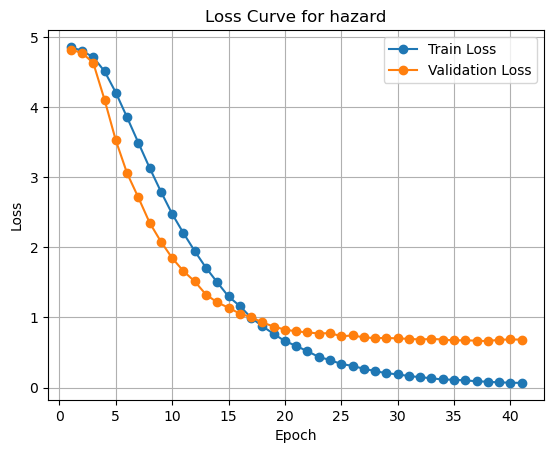

In [27]:
train_and_evaluate(train_dataloader, dev_dataloader, test_dataloader, le_hazard, 'hazard', "bert-mini_hazard")

### Label: Product

- We call the **`prepare_data`** function for the **product** column.

In [28]:
# Create DataLoader objects
train_dataloader, dev_dataloader, test_dataloader, le_product = prepare_data(train_df, 'product', tokenizer_distilbert)

Map:   0%|          | 0/5082 [00:00<?, ? examples/s]

Map:   0%|          | 0/565 [00:00<?, ? examples/s]

Map:   0%|          | 0/997 [00:00<?, ? examples/s]

- We call the **`train_and_evaluate`** function to train the model using the prepared data for the **"product"** label.

- For this task, we use **DistilBERT**, which is more efficient and suitable for the product label given its relatively larger number of classes compared to others.

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total Parameters: 67,831,670


  0%|          | 0/31800 [00:00<?, ?it/s]

Epoch 1: Avg Train Loss = 7.0445, Avg Validation Loss = 7.0155
Epoch 2: Avg Train Loss = 7.0205, Avg Validation Loss = 6.9423
Epoch 3: Avg Train Loss = 6.9246, Avg Validation Loss = 6.6795
Epoch 4: Avg Train Loss = 6.6510, Avg Validation Loss = 6.2718
Epoch 5: Avg Train Loss = 6.1661, Avg Validation Loss = 5.7733
Epoch 6: Avg Train Loss = 5.4751, Avg Validation Loss = 5.2825
Epoch 7: Avg Train Loss = 4.6378, Avg Validation Loss = 4.8935
Epoch 8: Avg Train Loss = 3.7609, Avg Validation Loss = 4.6194
Epoch 9: Avg Train Loss = 2.9017, Avg Validation Loss = 4.3518
Epoch 10: Avg Train Loss = 2.1990, Avg Validation Loss = 4.2341
Epoch 11: Avg Train Loss = 1.5945, Avg Validation Loss = 4.1402
Epoch 12: Avg Train Loss = 1.1335, Avg Validation Loss = 4.1331
Epoch 13: Avg Train Loss = 0.8208, Avg Validation Loss = 4.0868
Epoch 14: Avg Train Loss = 0.5881, Avg Validation Loss = 4.1296
No improvement in validation loss for 1 epochs.
Epoch 15: Avg Train Loss = 0.4573, Avg Validation Loss = 4.1154
N

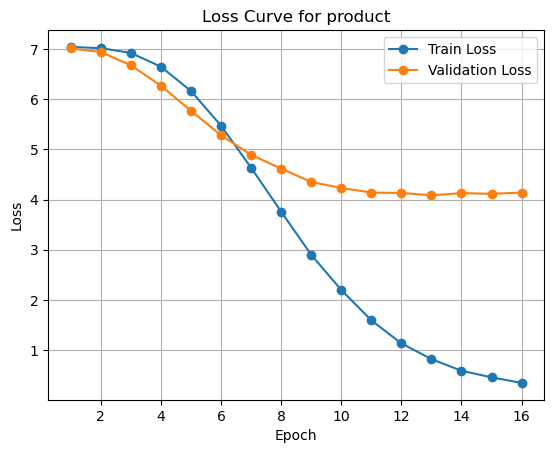

In [29]:
train_and_evaluate(train_dataloader, dev_dataloader, test_dataloader, le_product, 'product', "distilbert_product")

- Unfortunatelly, overfitting was observed here despite the efforts to tune the model.


- We compute the **validation scores for Sub-Task 2** by comparing the true labels for **hazard** and **product** with the predicted labels.

In [30]:
validation_score = compute_score(
    dev_df['hazard'], dev_df['product'],
    dev_df['predictions-hazard'], dev_df['predictions-product']
)
print(f"Validation Score Sub-Task 2: {validation_score:.3f}")

Validation Score Sub-Task 2: 0.476


- We also compute the **test scores for Sub-Task 2** by comparing the true labels for **hazard** and **product** with the predicted labels.

In [31]:
score = compute_score(
    test_df['hazard'], test_df['product'],
    test_df['predictions-hazard'], test_df['predictions-product']
)
print(f"Test Score Sub-Task 2: {score:.3f}")

Test Score Sub-Task 2: 0.470


## Predictions

- We load the tokenizer based on the model type (DistilBERT or BERT).

- We load the saved label encoder from a `.npy` file to map predictions back to labels.

- We load the trained model from the specified path, ensuring the correct architecture (DistilBERT or BERT).

- We make predictions using the trained model.

- We convert predicted indices back to their original class labels using the label encoder.

In [32]:
def predict(texts, model_path, tokenizer_path="prajjwal1/bert-mini"):
    # Load the saved tokenizer
    if 'distilbert' in tokenizer_path.lower():
        tokenizer = DistilBertTokenizer.from_pretrained(tokenizer_path)
    else:
        tokenizer = BertTokenizer.from_pretrained(tokenizer_path)
    
    # Load the saved label encoder
    label_encoder = LabelEncoder()
    label_encoder.classes_ = np.load(model_path + '/label_encoder.npy', allow_pickle=True)

    # Load the saved model
    if 'distilbert' in model_path.lower():
        model = DistilBertForSequenceClassification.from_pretrained(model_path)
    else:
        model = BertForSequenceClassification.from_pretrained(model_path)

    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Tokenize the input texts
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")

    # Move inputs to the same device as the model
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Set the model to evaluation mode
    model.eval()

    # Make predictions
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

    # Decode predictions back to string labels
    return label_encoder.inverse_transform(predictions.cpu().numpy().tolist())

- We use the `predict` function to generate predictions.  

In [33]:
predictions = pd.DataFrame()

for column in ['hazard-category', 'product-category', 'hazard', 'product']:
  if column == 'product':
    predictions[column] = predict(test_df.title.to_list(), f"distilbert_{column.replace('-', '_')}", tokenizer_path="distilbert-base-uncased")
  else:
    predictions[column] = predict(test_df.title.to_list(), f"bert-mini_{column.replace('-', '_')}")

predictions.sample()

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


,hazard-category,product-category,hazard,product
783,other hazard,fruits and vegetables,phenylpyrazole,kale


- Finally, We save the predictions as a CSV file inside a **"./submission/"** folder.  

- We zip the folder.  

In [34]:
import os
from shutil import make_archive

# Save predictions to a new folder:
os.makedirs('./submission/', exist_ok=True)
predictions.to_csv('./submission/submission.csv')

# Zip the folder
make_archive('./submission', 'zip', './submission')

'/home/ec2-user/SageMaker/submission.zip'